## Run this notebook in Google Colab by clicking here: [Google Colab](https://colab.research.google.com/github/AaronDJohnson/12p5yr_stochastic_analysis/blob/master/tutorials/ms_1vs2a.ipynb)

### Run these cells if using Colab. Otherwise, skip them!

In [ ]:
# This cell will reset the kernel.
# Run this cell, wait until it's done, then run the next.
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

In [ ]:
%%capture
!mamba install -y -c conda-forge enterprise_extensions
!pip install la_forge
!git clone https://github.com/AaronDJohnson/12p5yr_stochastic_analysis
import sys
sys.path.insert(0,'/content/12p5yr_stochastic_analysis/tutorials')
datadir = '/content/12p5yr_stochastic_analysis/tutorials/data'

# Load Pulsars

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np

from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals

from enterprise_extensions.models import model_2a
from enterprise_extensions import hypermodel

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

from la_forge import core, diagnostics

import sys
sys.path.append("..")
from settings import fd_bins

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get par, tim, and noise files

In [3]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = './data'

In [4]:
# for the entire pta
parfiles = sorted(glob.glob(datadir + '/par/*par'))
timfiles = sorted(glob.glob(datadir + '/tim/*tim'))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]
print(len(parfiles), 'pulsars')

45 pulsars


## Load into Pulsar class list

* The `enterprise` `Pulsar` class uses `libstempo` to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer need to reference the `par` and `tim` files after this cell.

* Note below that you can explicitly declare which version of the JPL solar-system ephemeris model that will be used to compute the Roemer delay between the geocenter and the barycenter (e.g. `DE438`). Otherwise the default values will be taken from the `par` files. Explicitly declaring the version here is good practice.

* You can also explicitly set the clock file to a version of `BIPM`, e.g. `BIPM(2018)`. This is less important, and you can let the code take the value from the `par` file.

* When you execute the following cell, you will get warnings like `WARNING: Could not find pulsar distance for PSR ...`. Don't worry! This is expected, and fine. Not all pulsars have well constrained distances, and will be set to `1 kpc` with a `20%` uncertainty.

## Read par and tim files into `enterprise` `Pulsar` objects

**Note**: This cell will take a few minutes to run the first time. The code will also save a version of the object as a `pickle` file. This will make loading the object much faster in the future at a cost of about 2 GB of disk space.

In [5]:
# check for file and load pickle if it exists:
pickle_loc = datadir + '/psrs.pkl'
if os.path.exists(pickle_loc):
    with open(pickle_loc, 'rb') as f:
        psrs = pickle.load(f)

# else: load them in slowly:
else:
    psrs = []
    ephemeris = 'DE438'
    for p, t in zip(parfiles, timfiles):
        psr = Pulsar(p, t, ephem=ephemeris)
        psrs.append(psr)

# Make your own pickle of these loaded objects to reduce load times significantly
# at the cost of some space on your computer (~1.8 GB).
with open(datadir + '/psrs.pkl', 'wb') as f:
    pickle.dump(psrs, f)

* We can read-in some previously computed noise properties from single-pulsar white noise analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 

* In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches.

* The noise properties have been stored as `json` files, and are read in to a big parameter dictionary.

In [6]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

# Using `enterprise` to search PTA data for an isotropic stochastic gravitational wave background

In this notebook you will learn:
* How to use `enterprise` to interact with pulsar timing data,
* How to search in PTA data for an isotropic stochastic gravitational wave background (SGWB) using multiple pulsars,
* How to post-process your results

## Set up `enterprise` model for PTA SGWB search

In [7]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

* We use the `Selection` object to define which noise parameters are assigned to which chunks of TOAs. This selection is based on unique combination of backends and receivers.

### Priors

* White noise is fixed by using `Constant` parameters. In this case we do not specify a default value for all instances of that parameter but instead will set them, based on their initialized pulsar and backend specific name, later via the `set_default_params` method of `PTA`. 

* Another feature to notice is that **for upper limits** we do not use a `Uniform` prior on the log of the red-noise or GWB amplitude. Instead we use a `LinearExp` prior (short for linear-exponent prior), that is a prior of the form $p(x)\propto 10^x$. This is how we can still use the log of the parameter to sample but place a uniform prior on the parameter itself. We do this for both the red noise and GWB amplitude parameters. **For detection analyses** we still use a `Uniform` prior on the log of the GWB amplitude. 

* We do not include spatial correlations here. Instead we model the GWB as a common red process across all pulsars. In `enterprise` we can do this with a simple trick. We pre-initialize the parameters before passing them to the `Signal` model. In this way the *same* parameter instance is used for all pulsars. Lastly, we fix the spectral index of the GWB to be 13/3 (~4.33) using the `Constant` parameter. This spectral index corresponds to a SGWB from an ensemble of supermassive black hole mergers.

In [8]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

In [9]:
# white noise parameters
efac = parameter.Constant() 
tnequad = parameter.Constant() 
ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.Uniform(-18, -14)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

### Signals
* Now we attach the priors to signals which will be added to make the full PTA model

In [10]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.TNEquadNoise(log10_tnequad=tnequad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
# change from 30 to 5 frequencies to line up with the real 12.5 year SGWB search
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=5, Tspan=Tspan, name='gw')

# for spatial correlations you can do...
# spatial correlations are covered in the hypermodel context later
# orf = utils.hd_orf()
# crn = gp_signals.FourierBasisCommonGP(cpl, orf,
#                                       components=30, Tspan=Tspan, name='gw')

# to add solar system ephemeris modeling...
bayesephem=False
if bayesephem:
    eph = deterministic_signals.PhysicalEphemerisSignal(use_epoch_toas=True)

# timing model
tm = gp_signals.TimingModel(use_svd=True)

### Full model

In [11]:
if bayesephem:
    s = ef + eq + ec + rn + tm + eph + gw
else:
    s = ef + eq + ec + rn + tm + gw

### Initialize PTA (this cell will take a minute or two to run)

In [12]:
models = []

for p in psrs:
    models.append(s(p))

pta = signal_base.PTA(models)

### Set white noise parameters with dictionary

In [13]:
pta.set_default_params(params)

### Set up PTMCMCSampler

In [14]:
# set initial parameters drawn from prior
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

In [16]:
# set up the sampler:
# initial jump sample covariance matrix - this is related to jump proposals and will not be discussed here
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = './chains/verbose_chains'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
                 outDir=outDir, resume=True)

### Sample!

Doing this sampling takes a very long time to get an adequate amount of samples. While you are welcome to do this yourself, we have included the samples from the posterior so that we can post process them and discuss the results immediately.

In [17]:
# sampler for N steps (uncomment the last line if you want to sample this yourself)
N = int(5e6)
x0 = np.hstack([p.sample() for p in pta.params])
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

## Plot output

In [18]:
# Uncomment this one to load the chain if you have sampled with PTMCMCSampler:
# chain = np.loadtxt(os.path.join(outDir, 'chain_1.0.txt'))

# This will load the chain that we have provided:
chain = np.load(os.path.join(outDir, 'chain_1.npz'))['arr_0']
burn = int(0.25 * chain.shape[0])  # remove burn in segment of sampling

In [23]:
# pick the index that contains log10_A_gw
ind = list(pta.param_names).index('log10_A_gw')

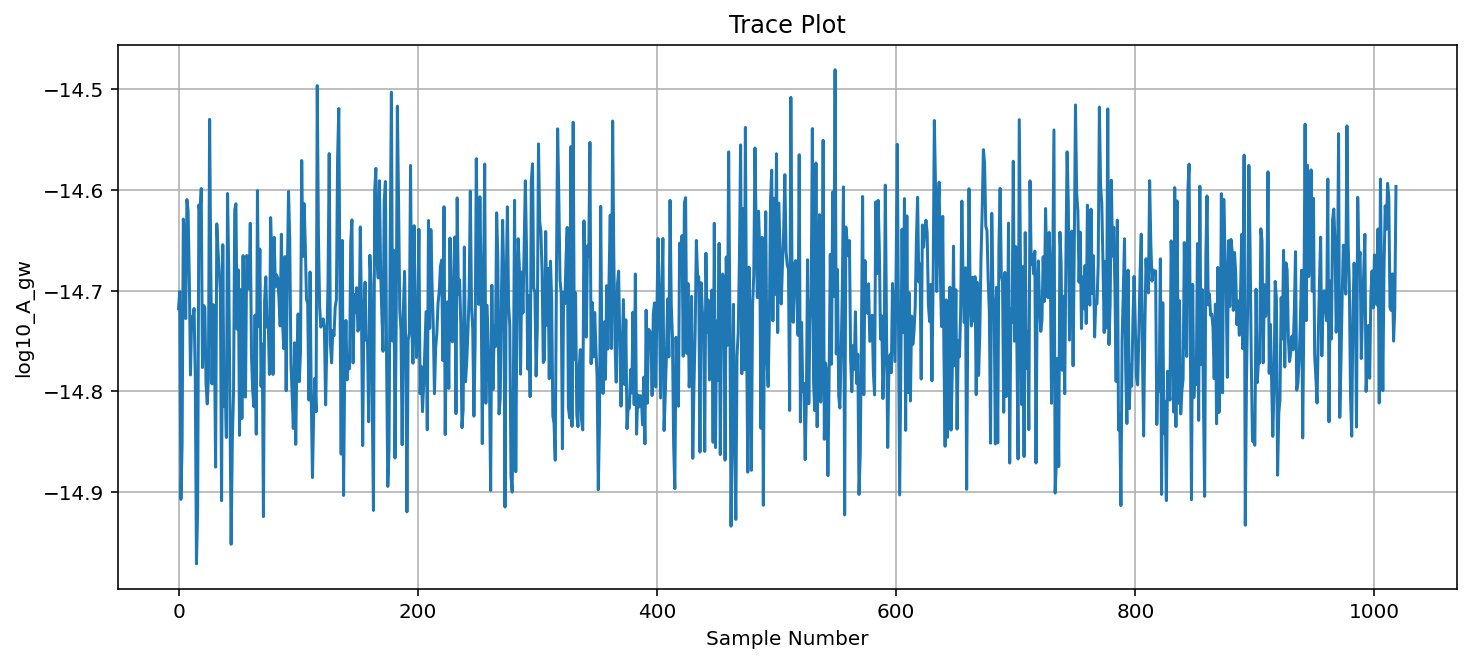

In [24]:
# Make trace-plot to diagnose sampling
# We want this plot to look more like a fuzzy caterpillar than a skinny worm
# While this doesn't look great, it has been thinned from a much longer chain.
plt.figure(figsize=(12, 5))
plt.plot(chain[burn:, ind])
plt.xlabel('Sample Number')
plt.ylabel('log10_A_gw')
plt.title('Trace Plot')
plt.grid(visible=True)
plt.show()

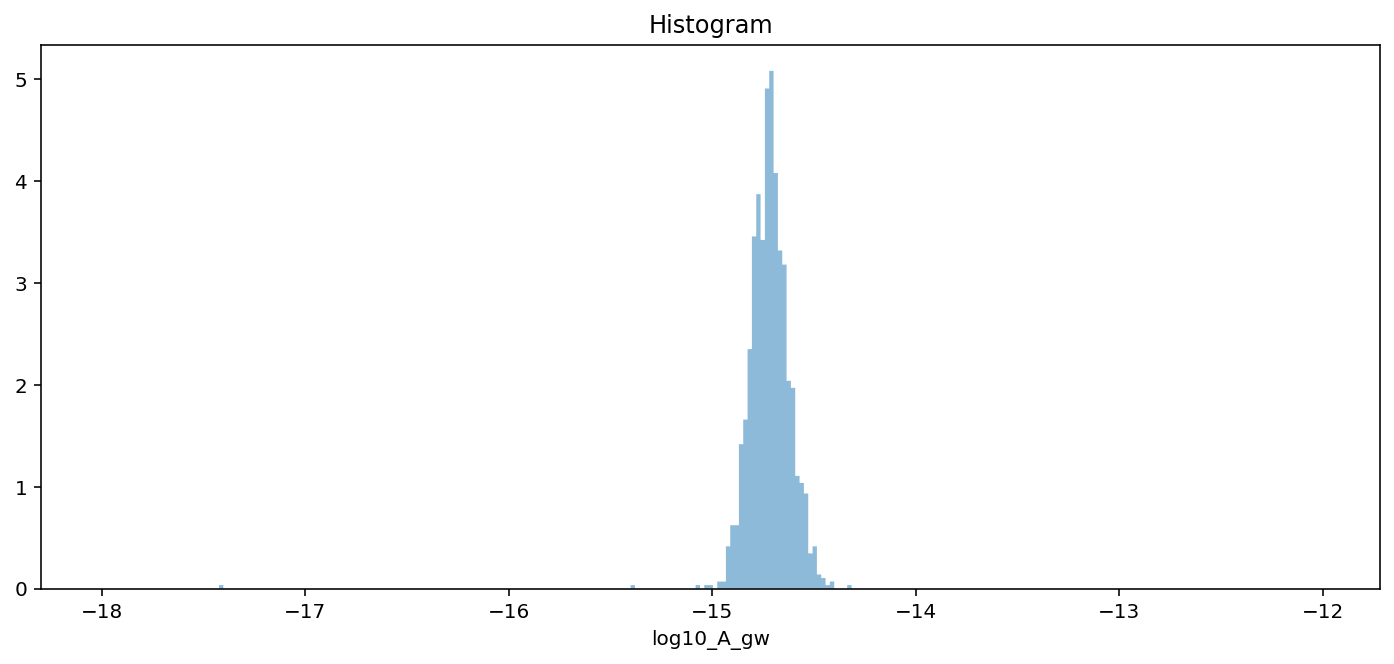

In [26]:
# Plot a histogram of the marginalized posterior distribution
bins = fd_bins(chain[:, ind], logAmin=-18, logAmax=-12)  # let FD rule decide bins (in ../settings.py)
plt.figure(figsize=(12, 5))
plt.title('Histogram')
plt.hist(chain[:, ind], bins=bins, histtype='stepfilled',
         lw=2, color='C0', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.show()

In [27]:
hist = np.histogram(chain[burn:, pta.param_names.index('log10_A_gw')],
                          bins=bins,
                          density=True)
max_ind = np.argmax(hist[0])
print('our_max =', hist[1][max_ind])  # from our computation

our_max = -14.720670877358558


## Discussion

* The posterior shows that there is strong evidence for a signal in the data. We can see this by examining the left side of the plot. If there were no or weak evidence for a signal here, the posterior would have a tail extending to the left as far as our prior extends (returning that part of the prior).
* `12p5yr_maxlike.json` shows `gw_log10_A` = -14.78 from the NANOGrav 12.5 year analysis
* Our maximum posterior value is `gw_log10_A` = -14.72
* In this situation we cannot use the Savage-Dickey density ratio to get a Bayes factor without special techniques, because there are no samples in the limit as this parameter goes to zero (the left side of the histogram above). After showing the fast way to do this using `enterprise_extensions`, we can discuss model selection using odds ratios.

# Using `enterprise_extensions` and `la_forge` to analyze PTA data

Now you will learn:
* How to use `enterprise_extensions` to create `enterprise` models,
* How to search in PTA data for a isotropic stochastic gravitational wave background using multiple pulsars,
* How to implement a HyperModel object to sample a `model_2a` model,
* How to post-process your results using `la_forge`

### Set up PTA model

* This model_2a includes everything from the verbose version in these tutorials:
    *    fixed white noise parameters based on noisedict `params`,
    *   common red noise signal (no correlation function) with 5 frequencies,
    *   and a spectral index of 13/3

In [30]:
pta = model_2a(psrs,
                psd='powerlaw',
                noisedict=params,
                n_gwbfreqs=5,  # modify the number of common red noise frequencies used here
                gamma_common=13/3,  # remove this line for a varying spectral index
                tm_marg=True,  # speed up the evaluations
                tm_svd=True,  # use SVD on the timing model
                tnequad=True)  # use old way of computing EQUAD

### Setup an instance of a HyperModel.
* This doesn't mean we are doing model selection (yet!), but the
 hypermodel module gives access to some nifty sampling schemes.

In [32]:
super_model = hypermodel.HyperModel({0: pta})

### Setup PTMCMCSampler

In [33]:
outDir = './chains/extensions_chains'

sampler = super_model.setup_sampler(resume=True,
                                    outdir=outDir,
                                    sample_nmodel=False,)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...



/Users/aaron/mambaforge/envs/rosettaprise/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [34]:
# sampler for N steps
N = int(5e6)
x0 = super_model.initial_sample()

In [35]:
# Sampling this will take a very long time. If you want to sample it yourself, uncomment the next line:
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

### Plot Output

In [36]:
# Uncomment this one to load the chain if you have sampled with PTMCMCSampler:
# chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))

# This will load the chain that we have provided:
chain = np.load(os.path.join(outDir, 'chain_1.npz'))['arr_0']
burn = int(0.25 * chain.shape[0])  # remove burn in segment of sampling

### Using `la_forge`
* Here we'll have a short discussion on how to use `la_forge` to...
  * save chains as compressed HDF5 files,
  * load chains to be used with `la_forge`
  * plot chains both as trace plots and histograms

* To save and load chains we use the `core.Core` object.
* ```core.Core(chaindir='./chains/sngl_gwb_ext/')```
* Errors about empty files are caused by us rewriting the chain folder when preparing the sampler above
* If you sample yourself, you should not see these errors

In [54]:
c1 = core.Core(chaindir=outDir)

/Users/aaron/mambaforge/envs/rosettaprise/lib/python3.9/site-packages/la_forge/core.py:178: UserWarning: loadtxt: Empty input file: "./chains/extensions_chains/draw_from_gwb_log_uniform_distribution_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=float)
/Users/aaron/mambaforge/envs/rosettaprise/lib/python3.9/site-packages/la_forge/core.py:178: UserWarning: loadtxt: Empty input file: "./chains/extensions_chains/draw_from_gw_log10_A_prior_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=float)
/Users/aaron/mambaforge/envs/rosettaprise/lib/python3.9/site-packages/la_forge/core.py:178: UserWarning: loadtxt: Empty input file: "./chains/extensions_chains/draw_from_red_prior_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=float)
/Users/aaron/mambaforge/envs/rosettaprise/lib/python3.9/site-packages/la_forge/core.py:178: UserWarning: loadtxt: Empty input file: "./chains/extensions_chains/draw_from_prior_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=float)


In [56]:
# To save the core
c1.save(outDir + '/core.hdf')

In [57]:
# To load the core
c1 = core.Core(corepath=outDir + '/core.hdf')

### Plotting with `la_forge`

* Plots in `la_forge` are done using the `diagnostics` module

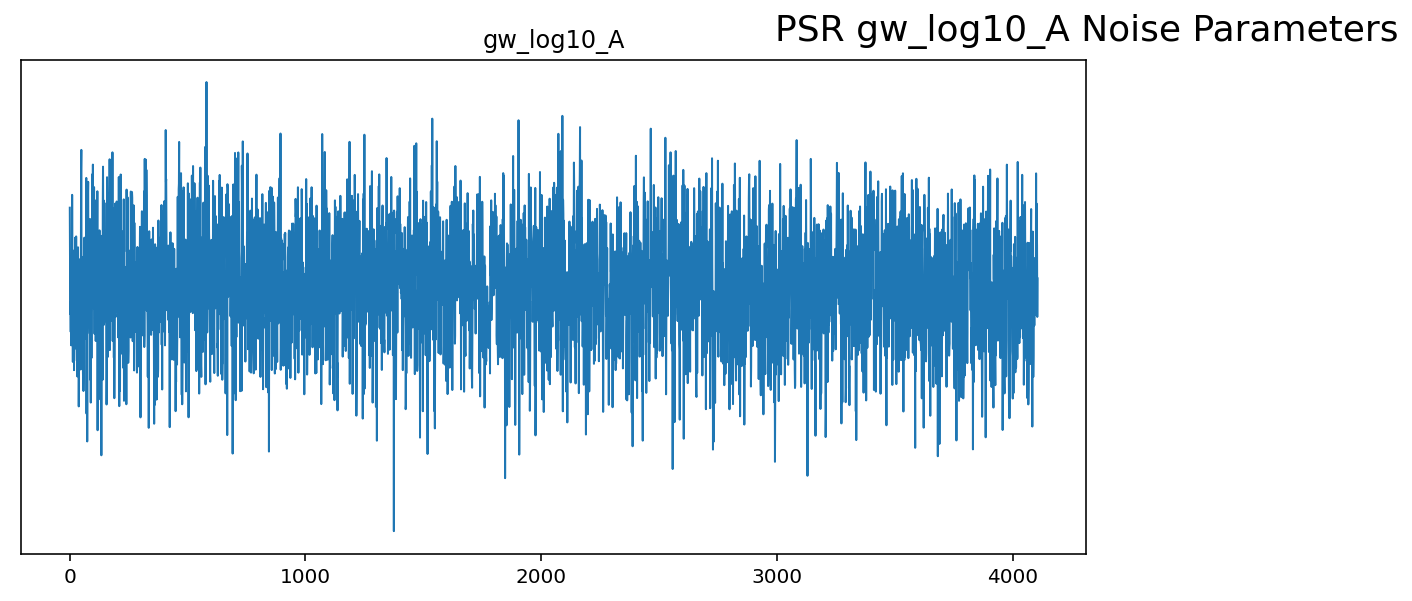

In [67]:
# To plot a trace plot for a specific parameter to diagnose sampling!
diagnostics.plot_chains(c1, hist=False, pars=['gw_log10_A'], ncols=2)

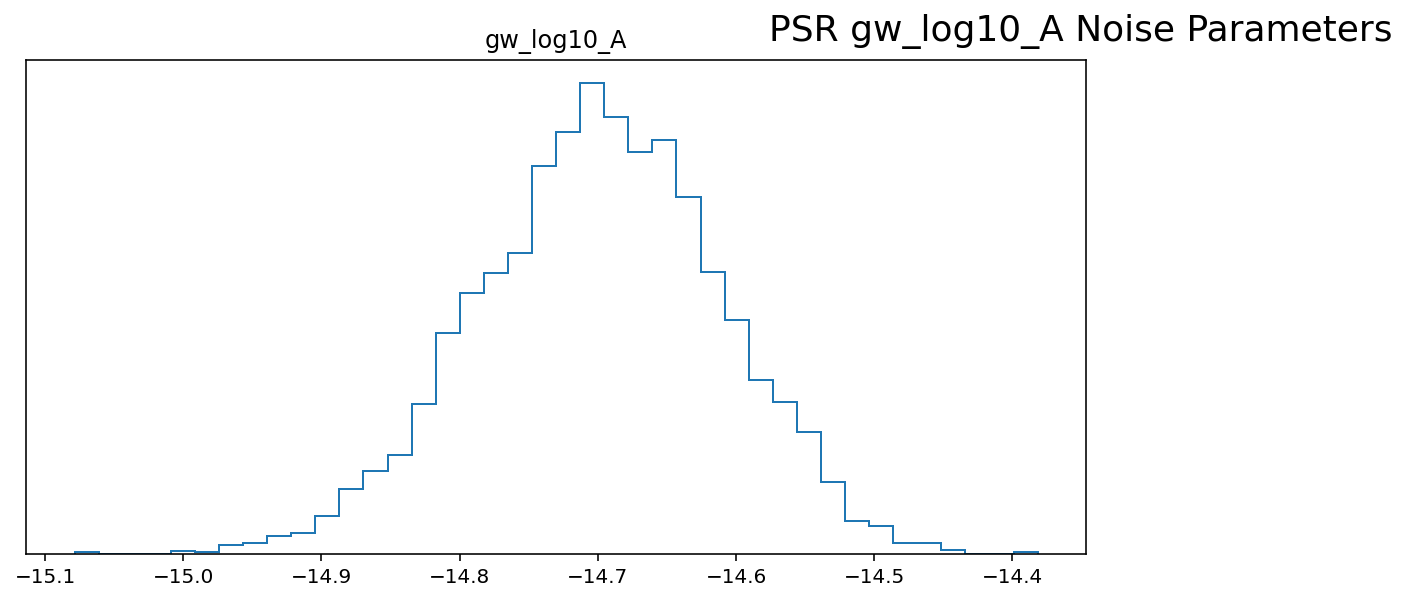

In [66]:
# Make a histogram plot for a specific parameter
diagnostics.plot_chains(c1, pars=['gw_log10_A'], ncols=2)


* To get a specific parameter in `la_forge`, we use `Core.get_param`

In [70]:
# Compute maximum posterior value
gw_log10_A = c1.get_param('gw_log10_A')
hist = np.histogram(gw_log10_A,
                    bins=bins,
                    density=True)
max_ind = np.argmax(hist[0])
print('our_max =', hist[1][max_ind])  # from our computation

our_max = -14.707808651660155


* This analysis is consistent with the verbose version.
### Here we have introduced some convenient methods:
* Using a HyperModel object for a single model,
* Using `enterprise_extensions` to create the model,
* Sampling a `HyperModel` with `PTMCMCSampler`.
* Using `la_forge` to save, load, and plot chains sampled with `PTMCMCSampler`